In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def bw_image(image_path, show=False):
    
    image = cv2.imread(image_path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, blockSize=11, C=2)
    img_gray = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
    
    if show:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot the first image on the left column
        axes[0].imshow(image_rgb)
        axes[0].set_title("Original Image")

        # Plot the second image on the right column
        axes[1].imshow(img_gray)
        axes[1].set_title("BW & High Contrast Image")

        # Adjust spacing between subplots
        plt.tight_layout()

        # Display the plot
        plt.show()

    
    return img_gray



In [3]:
def segment_white(image_path, show=False):
    
    image = cv2.imread(image_path)

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Set the saturation channel (index 1) to zero
    hsv[:, :, 1] = 0

    # Convert the image back to BGR color space
    result = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Increase the contrast using cv2.convertScaleAbs()
    alpha = 1.5  # Contrast factor
    beta = 0  # Brightness offset
    result = cv2.convertScaleAbs(result, alpha=alpha, beta=beta)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    
    gray_ = np.where(result > 200, 255, 0).astype(np.uint8)
    

    

    for i in range(3):
        gray = cv2.bitwise_and(gray_, result)
        gray = cv2.add(gray_, gray)
        result = gray

    gray = cv2.cvtColor(gray.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    if show:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot the first image on the left column
        axes[0].imshow(image_rgb)
        axes[0].set_title("Original Image")

        # Plot the second image on the right column
        axes[1].imshow(gray)
        axes[1].set_title("BW Segmented Image")

        # Adjust spacing between subplots
        plt.tight_layout()

        # Display the plot
        plt.show()

    return gray

In [4]:
def detect_plate(image_path, show=False):
    image = segment_white(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask of the same shape as the image
    mask = np.zeros_like(gray)

    # Iterate through the contours and draw filled contours on the mask
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Adjust the minimum area threshold as needed
            cv2.drawContours(mask, [contour], -1, (255, 255, 255), cv2.FILLED)

    # Apply the mask to the image
    result = cv2.bitwise_and(image, image, mask=mask)
    
    if show:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot the first image on the left column
        axes[0].imshow(image_rgb)
        axes[0].set_title("Original Image")

        # Plot the second image on the right column
        axes[1].imshow(result)
        axes[1].set_title("Segment Number Image")

        # Adjust spacing between subplots
        plt.tight_layout()

        # Display the plot
        plt.show()
    
    return result

In [5]:
def to_gray(image_path, show=False):
    
    image = cv2.imread(image_path)    
    # Convert the image to grayscale
    result = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    alpha = 1.2  # Contrast factor
    beta = 0  # Brightness offset
    result = cv2.convertScaleAbs(result, alpha=alpha, beta=beta)
    
    if show:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # Plot the first image on the left column
        axes[0].imshow(image_rgb)
        axes[0].set_title("Original Image")

        # Plot the second image on the right column
        axes[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        axes[1].set_title("BW Image")

        # Adjust spacing between subplots
        plt.tight_layout()

        # Display the plot
        plt.show()
    
    return result

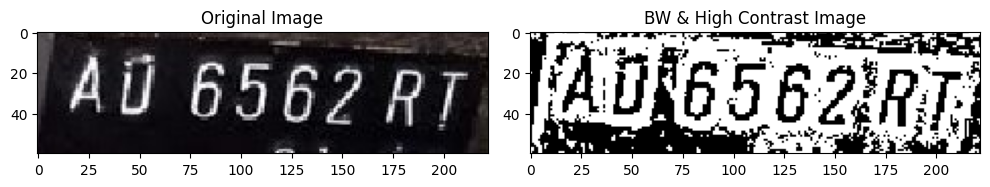

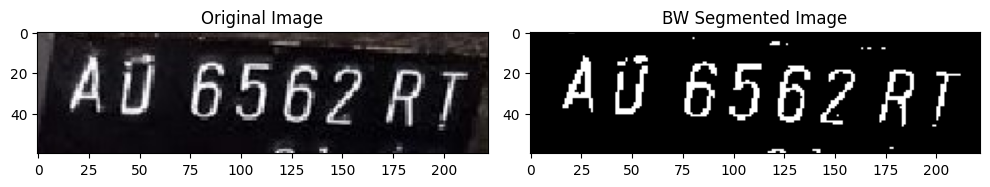

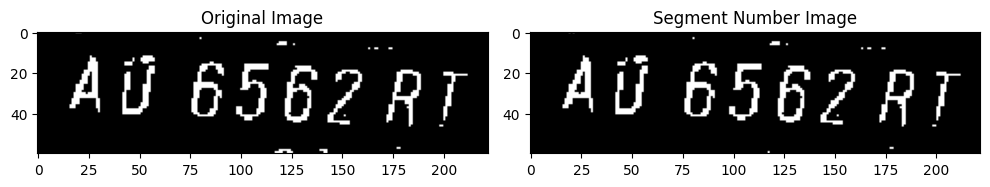

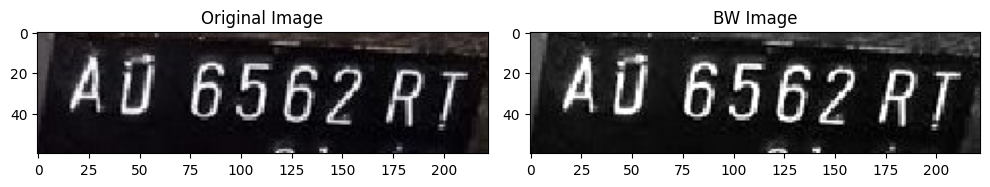

In [11]:
# Example usage
import random 
rand = random.randint(0, 600)+1
input_image = f'train/DataTrain{rand}.png'
output_image = bw_image(input_image, show=True)
output_image = segment_white(input_image, show=True)
output_image = detect_plate(input_image, show=True)
output_image = to_gray(input_image, show=True)


# cv2.imwrite('test_unskew.jpg', output_image)


In [16]:
import cv2
import numpy as np
import imgaug.augmenters as iaa

def image_augmentation(image, label, num_augmentations):
    # Create augmentation sequence
    augmenter = iaa.Sequential([
            iaa.Affine(rotate=(-25, 25)),  # Rotate the image by a random angle between -10 and 10 degrees
            iaa.GaussianBlur(sigma=(0, 2)),  # Apply random Gaussian blur with a sigma between 0 and 1.0
            iaa.AdditiveGaussianNoise(scale=(0, 0.015 * 255)),  # Add random Gaussian noise to the image
            iaa.Multiply((0.8, 1.1)),  # Multiply pixel values by a random value between 0.8 and 1.2
            iaa.ContrastNormalization((0.9, 1.1)),  # Apply contrast normalization to the image
            iaa.MultiplyHueAndSaturation((0.9, 1.1), per_channel=True),  # Multiply hue and saturation by a random value
            iaa.Affine(shear=(-15, 15)),  # Add skewing with shear transformation
            iaa.AdditiveLaplaceNoise(scale=(0, 0.015 * 255)),  # Additional noise
            iaa.GammaContrast(gamma=(0.9, 1.1)),  # Random gamma and contrast adjustment
            ])

    # Create empty lists to store augmented images and labels
    augmented_images = []
    augmented_labels = []

    # Augment the image and label multiple times
    for _ in range(num_augmentations):
        # Apply augmentation to the image
        augmented_image = augmenter.augment_image(image)
        # Append the augmented image and its corresponding label to the lists
        augmented_images.append(augmented_image)
        augmented_labels.append(label)

    # Convert lists to NumPy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    return augmented_images, augmented_labels


In [8]:
! pip install -q imgaug

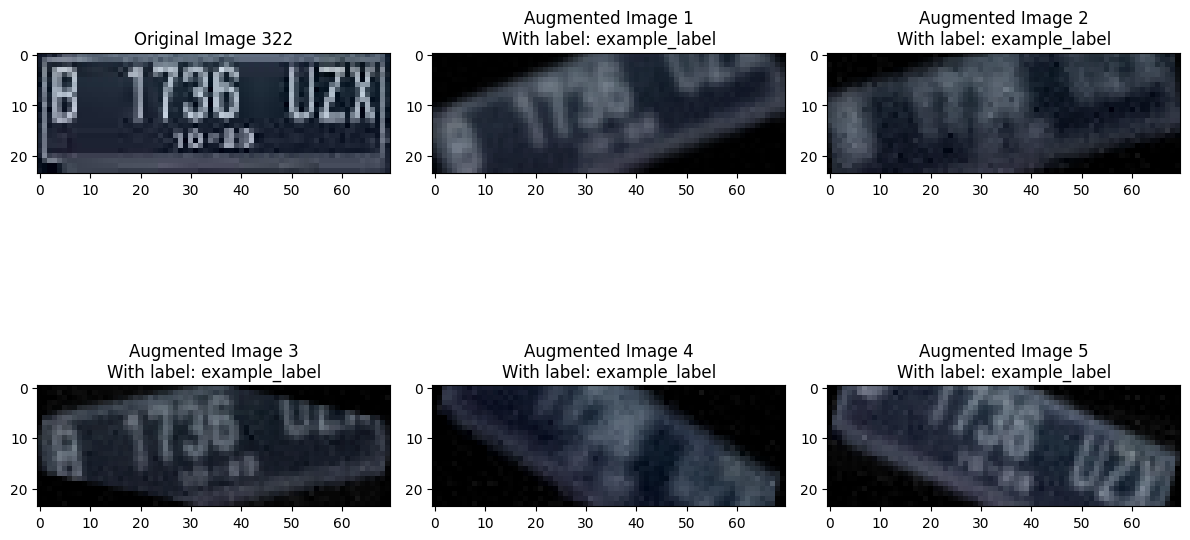

In [22]:
import matplotlib.pyplot as plt

import random 
rand = random.randint(0, 600)+1
# Example image and label
image_path = f'train/DataTrain{408}.png'
label = "example_label"

# Load the image
image = cv2.imread(image_path)

# Call the image_augmentation function
num_augmentations = 5  # Number of augmented images to generate
augmented_images, augmented_labels = image_augmentation(image, label, num_augmentations)

# Create the subplot grid
n = 2  # Number of rows
m = 3  # Number of columns
fig, axes = plt.subplots(n, m, figsize=(12, 8))

# Display the original image
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f"Original Image {rand}")

# Display the augmented images
for i, augmented_image in enumerate(augmented_images):
    row = (i + 1) // m
    col = (i + 1) % m
    axes[row, col].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f"Augmented Image {i+1}\nWith label: {augmented_labels[i]}")

# Remove empty subplots
if num_augmentations < (n * m - 1):
    for i in range(num_augmentations + 1, n * m):
        row = i // m
        col = i % m
        fig.delaxes(axes[row, col])

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


In [10]:
cv2.imwrite("unskewed_image.jpg", unskewed_image)


NameError: name 'unskewed_image' is not defined